In [1]:
import os
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

def setup_data():
    print("--- Starting Data Download/Load ---")
    
    # 1. Download/Load Tiny ImageNet
    # This will download once and cache it in ~/.cache/huggingface/
    dataset = load_dataset("zh-plus/tiny-imagenet")
    
    print("\n--- Dataset Summary ---")
    print(dataset)
    
    # 2. Verify splits
    # Tiny ImageNet contains 100,000 images.
    train_count = len(dataset['train'])
    val_count = len(dataset['valid'])
    print(f"Training images: {train_count}")
    print(f"Validation images: {val_count}")

    # 3. Simple EDA: Visualizing a few samples
    # This addresses the 'Data processing: EDA' requirement[cite: 10, 11].
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        sample = dataset['train'][i]
        img = sample['image']
        label = sample['label']
        
        # Tiny ImageNet images are 64x64.
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.show()
    
    return dataset

/home/punny/anaconda3/envs/tiny_net/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Starting Data Download/Load ---

--- Dataset Summary ---
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})
Training images: 100000
Validation images: 10000


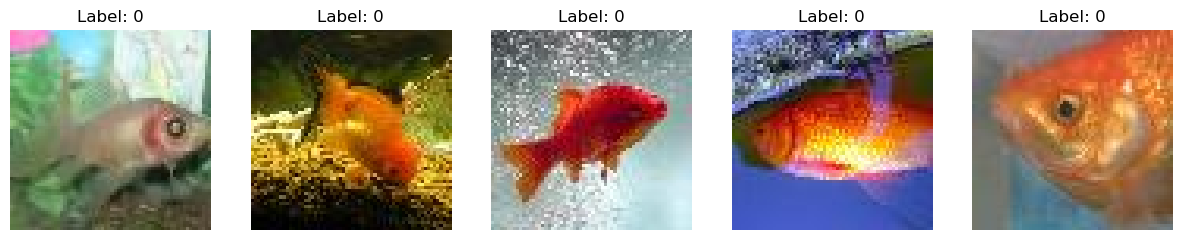

In [2]:
ds = setup_data()